In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
import scipy.stats as sts

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [3]:
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
data.columns = data.columns.str.lower()

## Initial Model

In [4]:
regr = linear_model.LinearRegression()
Y = data['sales'].values.reshape(-1, 1)
X = data[['tv','radio','newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


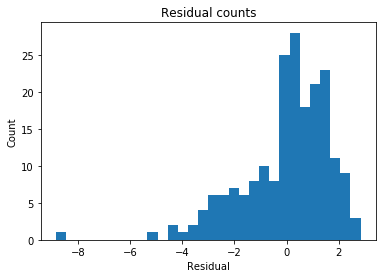

In [5]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual, bins=30)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## Investigating univariate distributions

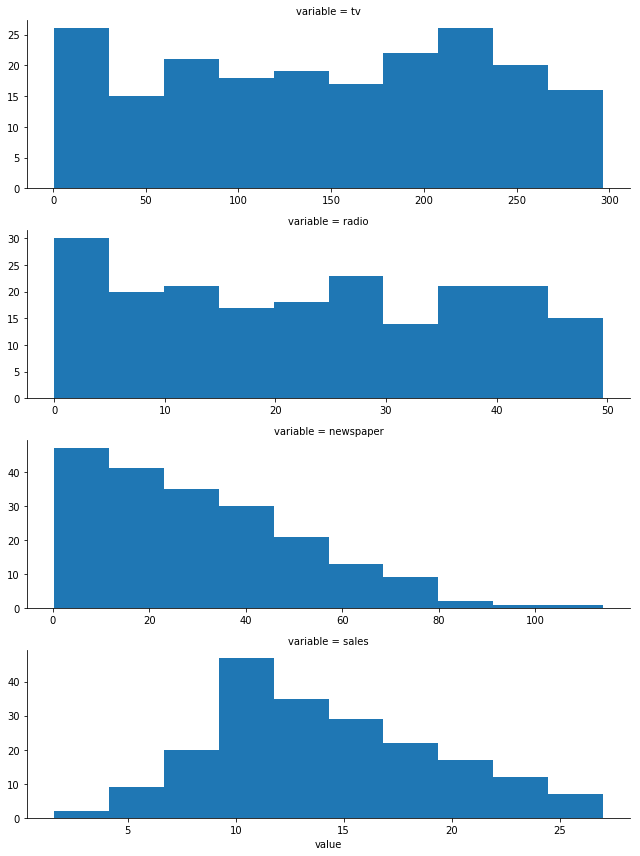

In [6]:
# Get rid of newspaper outliers
new = data.iloc[:, 1:].melt()

g = sns.FacetGrid(new, row='variable', aspect=3, sharex=False, sharey=False)
g.map(plt.hist, 'value')
plt.show()

## Investigating bivariate relationships

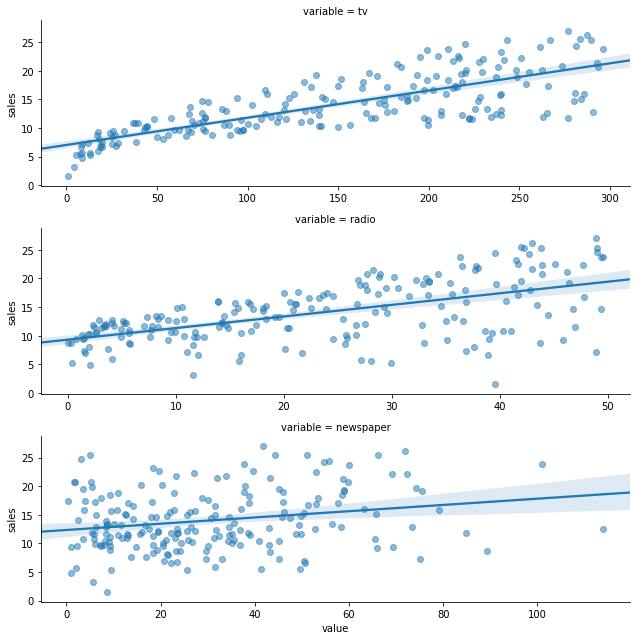

In [11]:
bi = data.iloc[:, 1:].melt(id_vars='sales')
g = sns.FacetGrid(bi, row='variable', aspect=3, sharex=False)
g.map(sns.regplot, 'value', 'sales', scatter_kws={'alpha': 0.5})
plt.show()

In [7]:
data[['sales', 'newspaper', 'tv', 'radio']].corr()

,sales,newspaper,tv,radio
sales,1.000,0.228,0.782,0.576
newspaper,0.228,1.000,0.057,0.354
tv,0.782,0.057,1.000,0.055
radio,0.576,0.354,0.055,1.000


## Alternate Model 1: Drop newspaper
Looking at the bivariate plots, newspaper exhibits no relationship whatsoever.

In [8]:
m1 = linear_model.LinearRegression()
Y = data['sales'].values.reshape(-1, 1)
X = data[['tv','radio']]
m1.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', m1.coef_)
print('\nIntercept: \n', m1.intercept_)
print('\nR-squared:')
print(m1.score(X, Y))


Coefficients: 
 [[0.04575482 0.18799423]]

Intercept: 
 [2.92109991]

R-squared:
0.8971942610828956


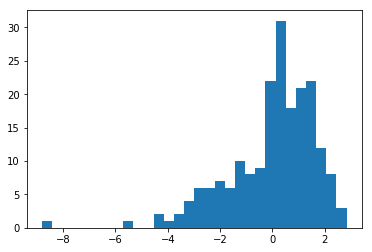

In [9]:
predicted = m1.predict(X).ravel()
residual = data.sales - predicted
plt.hist(residual, bins=30)
plt.show()

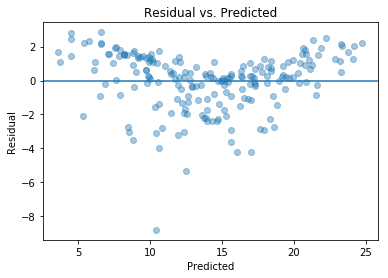

In [10]:
plt.scatter(predicted, residual, alpha=0.4)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Alternate model 2: Correcting TV
The scatterplot of TV and Sales demonstrates a relationship that looks much closer to a logrithmic relationship than linear. This might explain why the residuals appear to have a curve. For completion, I charted bivariate scatterplots with the following transformations of tv.
- Raising e to the x power
- Square tv value
- "Raise" to the 0.8 power
- Squareroot of tv value
- "Raise" to the 0.2 power
- Inverse

In [24]:
data['tv_exp'] = np.exp(data.tv)
data['tv_sq'] = np.square(data.tv)
data['tv_rt1'] = data.tv.apply(lambda x: pow(x, 0.8))
data['tv_sqrt'] = np.sqrt(data.tv)
data['tv_rt2'] = data.tv.apply(lambda x: pow(x, 0.2))
data['tv_inv'] = data.tv.apply(lambda x: 1/x)

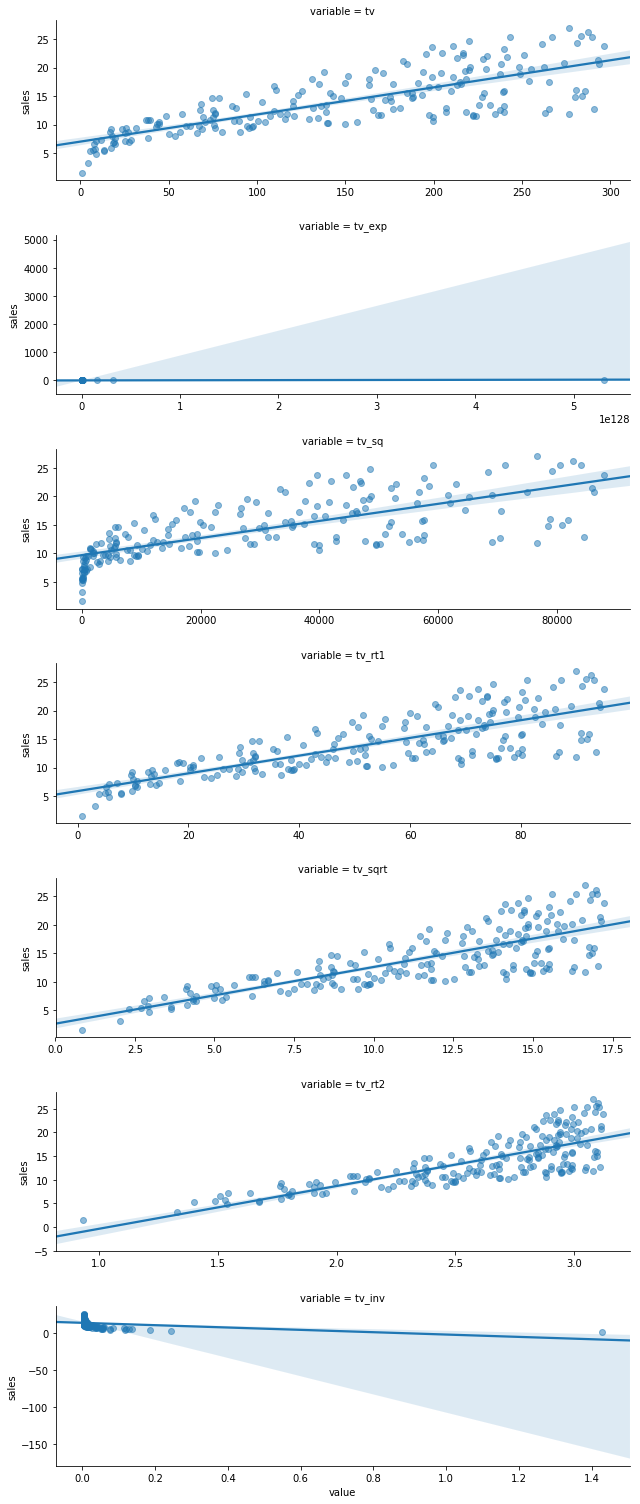

In [25]:
tv = data.loc[:, pd.Series(data.columns).loc[data.columns.str.contains('tv')]\
              .append(pd.Series('sales'))].copy()
tv = tv.melt(id_vars='sales')

g = sns.FacetGrid(tv, row='variable', sharex=False, sharey=False, aspect=3)
g.map(sns.regplot, 'value', 'sales', scatter_kws={'alpha': 0.5})
plt.show()

### Alternate Model 3: Square root of TV values

In [47]:
mintv = data.tv_sqrt.sort_values()[:2].index
m2_data = data.loc[list(filter(lambda x: x not in mintv, data.index)), ['tv_sqrt', 'tv_rt2', 'radio', 'sales']]

In [42]:
m2 = linear_model.LinearRegression()
Y = m2_data['sales'].values.reshape(-1, 1)
X = m2_data[['tv_sqrt', 'radio']]
m2.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', m2.coef_)
print('\nIntercept: \n', m2.intercept_)
print('\nR-squared:')
print(m2.score(X, Y))


Coefficients: 
 [[0.95864368 0.19680613]]

Intercept: 
 [-1.46135913]

R-squared:
0.9309159215358214


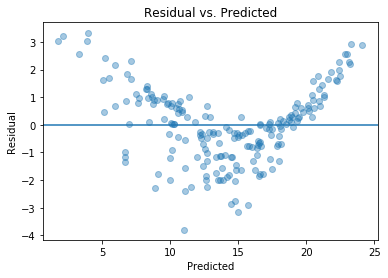

In [48]:
predicted = m2.predict(X).ravel()
residual = m2_data.sales-predicted

plt.scatter(predicted, residual, alpha=0.4)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

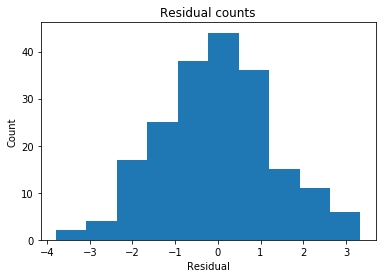

In [44]:
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [49]:
m2_alt = linear_model.LinearRegression()
Y = m2_data['sales'].values.reshape(-1, 1)
X = m2_data[['tv_rt2', 'radio']]
m2_alt.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', m2_alt.coef_)
print('\nIntercept: \n', m2_alt.intercept_)
print('\nR-squared:')
print(m2_alt.score(X, Y))


Coefficients: 
 [[9.03929717 0.20153274]]

Intercept: 
 [-14.10862622]

R-squared:
0.9258127473314722


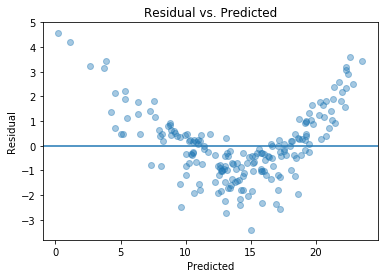

In [51]:
predicted = m2_alt.predict(X).ravel()
residual = m2_data.sales-predicted

plt.scatter(predicted, residual, alpha=0.4)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Alternate Model 4: Droping small values for TV to fix residual distribution

In [77]:
tv50 = data.loc[data.tv>50]

m3 = linear_model.LinearRegression()
Y = tv50['sales'].values.reshape(-1, 1)
X = tv50[['tv', 'radio']]
m3.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', m3.coef_)
print('\nIntercept: \n', m3.intercept_)
print('\nR-squared:')
print(m3.score(X, Y))


Coefficients: 
 [[0.03542016 0.22648902]]

Intercept: 
 [4.11402774]

R-squared:
0.9449625974516831


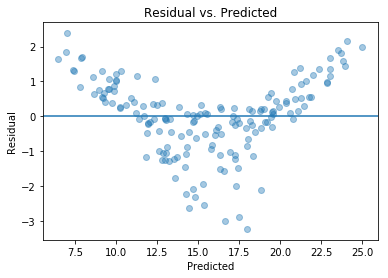

In [78]:
predicted = m3.predict(X).ravel()
residual = tv50.sales-predicted

plt.scatter(predicted, residual, alpha=0.4)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

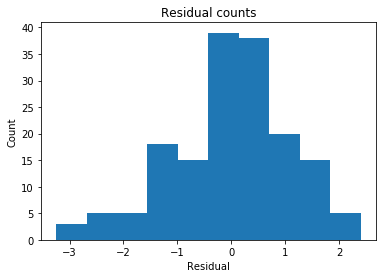

In [79]:
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### Alternate Model 5: Drop high values for TV (above 250)

In [80]:
data['tv_cub'] = data.tv.apply(lambda x: pow(x, 3))
tv250 = data.loc[data.tv<250]


m5 = linear_model.LinearRegression()
Y=tv250['sales'].values.reshape(-1, 1)
X=tv250[['tv_cub', 'radio']]
m5.fit(X, Y)

print('\nCoefficients: \n', m5.coef_)
print('\nIntercept: \n', m5.intercept_)
print('\nR-squared:')
print(m5.score(X, Y))


Coefficients: 
 [[6.71623357e-07 1.63676348e-01]]

Intercept: 
 [6.56687509]

R-squared:
0.7348081513191063


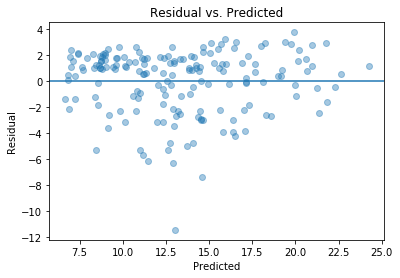

In [81]:
predicted = m5.predict(X).ravel()
residual = tv250.sales-predicted

plt.scatter(predicted, residual, alpha=0.4)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

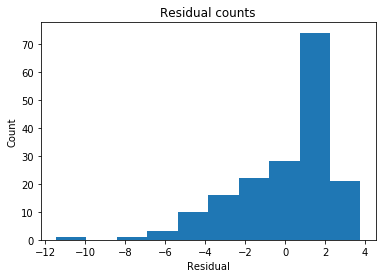

In [69]:
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### Transform radio

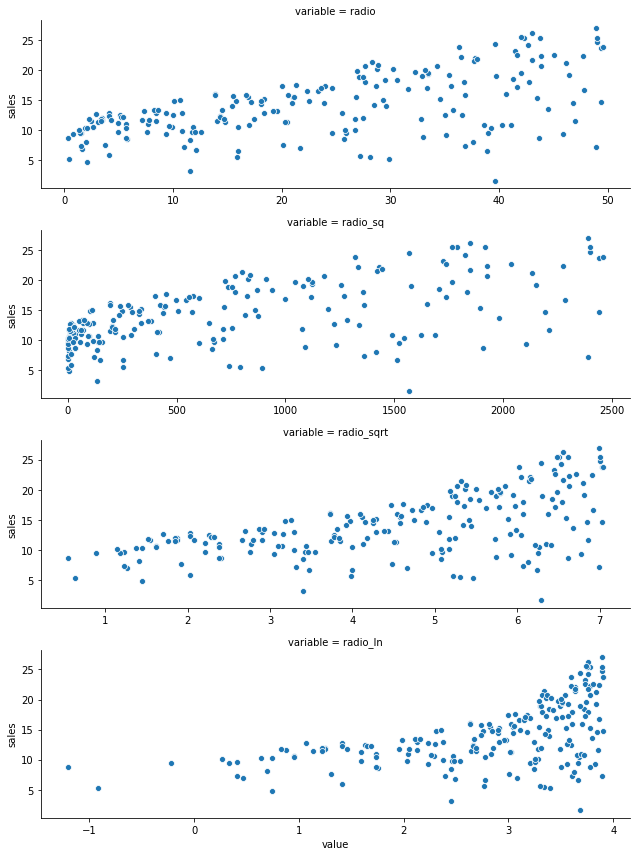

In [91]:
data_ln = data.loc[data.radio!=0].copy()

data_ln.loc[:, 'radio_sq'] = np.square(data_ln.radio)
data_ln.loc[:, 'radio_sqrt'] = np.sqrt(data_ln.radio)
data_ln.loc[:,'radio_ln'] = np.log(data_ln.radio)

ln_lng = data_ln.loc[:, ['sales', 'radio', 'radio_sq', 'radio_sqrt', 'radio_ln']].melt(id_vars='sales')

g = sns.FacetGrid(ln_lng, row='variable', sharex=False, sharey=False, aspect=3)
g.map(sns.scatterplot, 'value', 'sales')
plt.show()

In [98]:
m6_data = data_ln.loc[data_ln.radio_sqrt>1]


m6 = linear_model.LinearRegression()
Y = m6_data.sales.values.reshape(-1, 1)
X = m6_data[['tv_sq', 'radio_sqrt']]
m6.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', m6.coef_)
print('\nIntercept: \n', m6.intercept_)
print('\nR-squared:')
print(m6.score(X, Y))


Coefficients: 
 [[1.43420791e-04 1.58301321e+00]]

Intercept: 
 [2.69099689]

R-squared:
0.8001894013055307


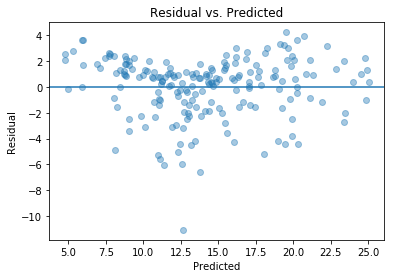

In [99]:
predicted = m6.predict(X).ravel()
residual = m6_data.sales-predicted

plt.scatter(predicted, residual, alpha=0.4)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

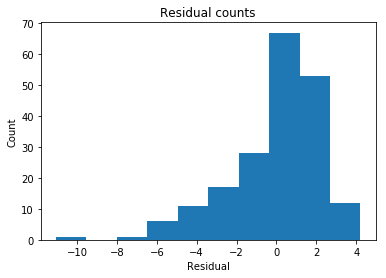

In [100]:
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## Final model
- Dropped newspaper
- Eliminate bottom 50 datapoints from tv
- Transform tv to sqrt

In [63]:
tv50['tv_sq'] = np.sqrt(tv50.tv)

mf = linear_model.LinearRegression()
Y = tv50['sales'].values.reshape(-1, 1)
X = tv50[['tv_sq', 'radio']]
mf.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', mf.coef_)
print('\nIntercept: \n', mf.intercept_)
print('\nR-squared:')
print(mf.score(X, Y))


Coefficients: 
 [[0.88323138 0.22617825]]

Intercept: 
 [-1.11003582]

R-squared:
0.9430302603981474


C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


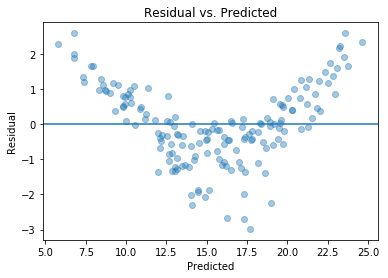

In [64]:
predicted = mf.predict(X).ravel()
residual = tv50.sales-predicted

plt.scatter(predicted, residual, alpha=0.4)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

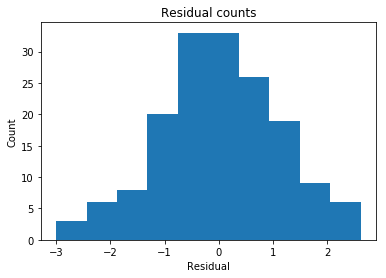

In [65]:
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()